# Clase "Data"

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
class Data(Dataset):
  def __init__(self, file, first_col, x_columns):
    dataset = np.genfromtxt(file, delimiter=",", skip_header=1)
    x = dataset[:,first_col:x_columns]
    y = dataset[:,x_columns]
    self.x=torch.from_numpy(x).type(torch.FloatTensor)
    self.y=torch.from_numpy(y).type(torch.FloatTensor).view(self.x.shape[0],1)
    self.len=y.shape[0]

  def __getitem__(self, index):
    return self.x[index],self.y[index]

  def __len__(self):
    return self.len

  def normalizar(self):
    std_sc = StandardScaler()
    self.x = torch.from_numpy(std_sc.fit_transform(self.x.numpy())).type(torch.FloatTensor)
    return

  def validacionCruzada(self, indice, particiones):
    aux = []
    for i in range(len(particiones)):
      if i != indice:
        aux.append(particiones[i])
    dataTrain = torch.utils.data.ConcatDataset(aux)
    dataTest = particiones[indice]
    return dataTrain,dataTest

# Clase "Red Neuronal"

In [ ]:
from torch import nn
import math
from sklearn.metrics import confusion_matrix
class RedNeuronal(nn.Module):
  #se le pasa una lista con las neuronas que contiene cada capa, el primer valor es
  #el tamano del vector de entrada
  #y el utimo el valor de la salida.
  def __init__(self, Layers, ActivationFunct, typeWeights = None ):
    super(RedNeuronal,self).__init__()
    self.hidden = nn.ModuleList()
    for input_size,output_size in zip(Layers,Layers[1:]):
      linear = nn.Linear(input_size,output_size)
      if typeWeights == "xavier":
        torch.nn.init.xavier_uniform_(linear.weight)
      if typeWeights == "uniform":
        linear.weight.data.uniform_(0, 1)
      self.hidden.append(linear)
    self.ActivationF = ActivationFunct

  #aplica la red neuronal a unos datos(activation)
  def forward(self, activation):
    L=len(self.hidden)
    for (l,linear_transform) in zip(range(L),self.hidden):
      if l<L-1:
        activation =self.ActivationF[l](linear_transform (activation))
      else:
        if len(self.ActivationF) == len(self.hidden):
          activation = self.ActivationF[l](linear_transform (activation))
        else:
          activation =linear_transform (activation)
    return activation

  #entrenamiento de la red neuronal de varias capas
  def train(self, dataTrain, optimizer, criterion, train_loader, epochs=100):
    LOSS=[]
    min_loss = 10000000000
    for epoch in range(epochs):
      for x, y in train_loader:
        yhat=self(x)
        loss=criterion(yhat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss.item() < min_loss:
          value = epoch
          min_loss = loss.item()
          torch.save(self.state_dict(), 'best_model.pt')
        LOSS.append(loss.item())
    return LOSS,value,min_loss

  def predict(self, dataTest, criterion):
    yhat = self(dataTest[0:-1][0]).detach().numpy()
    yhat = np.clip(yhat,5,yhat.max())
    yhat = torch.from_numpy(yhat)
    loss = criterion(yhat,dataTest[0:-1][1])
    return loss.item()
  def scoreSigmoid(self, dataTest):
    yhat = self(dataTest[0:-1][0])
    lable = yhat > 0.5
    cm = confusion_matrix(np.array(dataTest[0:-1][1]),lable)
    return torch.mean((lable== dataTest[0:-1][1].type(torch.ByteTensor)).type(torch.float)),cm

# Importar librerías


In [ ]:
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Preparar el conjunto de datos

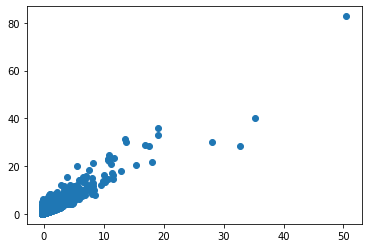

In [ ]:
from google.colab import files
#!rm vgsales.csv
#!rm vgsales2.csv
#uploaded = files.upload()
#!ls

dataHousing = Data("./vgsales2.csv", 0, 1)
dataHousing.normalizar()
plt.scatter(dataHousing.x, dataHousing.y)
plt.show()

# Cargador de Datos

In [ ]:
torch.manual_seed(1)
num_partVC = 43
lenVC = int(len(dataHousing)/num_partVC)
lengths = ()
for i in range(num_partVC):
  lengths = lengths + (lenVC,)
particiones = random_split(dataHousing, lengths)

# Crear la RNA

Red Neuronal una capa oculta
perdida en iteracion 1 : 21.495153427124023 r2:  -23.18212992382078
perdida en iteracion 2 : 21.27256965637207 r2:  -15.374086055460332
perdida en iteracion 3 : 21.26702308654785 r2:  -11.539606513063559
perdida en iteracion 4 : 21.131473541259766 r2:  -7.762987313127496
perdida en iteracion 5 : 21.232620239257812 r2:  -9.177500882519395
perdida en iteracion 6 : 21.049442291259766 r2:  -19.115846371645908
perdida en iteracion 7 : 23.895374298095703 r2:  -4.408829321190002
perdida en iteracion 8 : 21.108278274536133 r2:  -3.9538407068585615
perdida en iteracion 9 : 21.373363494873047 r2:  -16.668428547105368
perdida en iteracion 10 : 21.413270950317383 r2:  -10.385085920315026
perdida en iteracion 11 : 21.221786499023438 r2:  -32.87550443198668
perdida en iteracion 12 : 21.235361099243164 r2:  -10.623930869704074
perdida en iteracion 13 : 21.489364624023438 r2:  -10.811078935998514
perdida en iteracion 14 : 21.395700454711914 r2:  -10.579846950315106
perdida

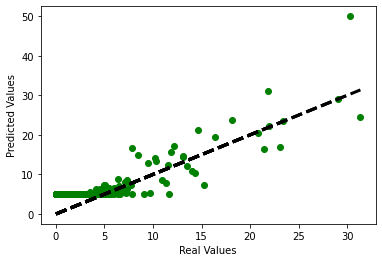

In [ ]:
#red neuronal profunda
#defino el criterio que se va a usar(Mean Square Error) y el optimizador(descenso por gradientte)
print("Red Neuronal una capa oculta")
ACC=[]
r2=[]
learning_rate=0.01
LAYERS=[1,20,1]
ActivationFunctions = [F.relu]
criterion=torch.nn.MSELoss()
fig, ax = plt.subplots()
for i in range(num_partVC):
  if i >= 15:
    break
  dataTrain, dataTest = dataHousing.validacionCruzada(i, particiones)
  model = RedNeuronal(LAYERS,ActivationFunctions,"uniform")
  optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate,weight_decay=0.01)
  LOSS=[]
  trainLoader = DataLoader(dataset=dataTrain,batch_size=50)
  LOSS,epoch,min_loss = model.train(dataHousing,optimizer,criterion,trainLoader,50)
  model_best = RedNeuronal(LAYERS,ActivationFunctions)
  model_best.load_state_dict(torch.load('best_model.pt'))
  ACC.append(model_best.predict(dataTest, criterion))
  output = model_best(dataTest[0:-1][0]).detach().numpy()
  labels = np.array(dataTest[0:-1][1])
  output = np.clip(output,5,50)
  ax.scatter(labels, output, color="green")
  ax.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'k--', lw=3)
  ax.set_xlabel('Real Values')
  ax.set_ylabel('Predicted Values')
  r2.append(r2_score(labels,output))
  print("perdida en iteracion", i + 1, ":", ACC[-1],"r2: ", r2[-1])
print("perdida media: ", sum(ACC)/num_partVC, " y r2 medio: ", sum(r2)/num_partVC)
plt.show()